In [1]:
# libraries imported
suppressPackageStartupMessages({
library('ggplot2'); # visualisation (used)
library('tidyr') # visuatilisation (used)
library('grid') # visualisation (used)
library('dplyr'); # data manipulation (used)
library('data.table'); # data manipulation (used)
library('tibble'); # data wrangling (used)
library('lubridate'); # date and time (used)
library('geosphere'); # geospatial locations (used)
library('leaflet'); # maps (used)
library('fastDummies'); # one-hot encoding (used)
})

options(dplyr.summarise.inform = FALSE)

In [2]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  
  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  
  numPlots = length(plots)
  
  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))
  }
  
  if (numPlots==1) {
    print(plots[[1]])
    
  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

## multiplot function is imported in a hidden cell

Our kernel main purpose is to make a decent EDA and Feature engineer our data   
for a better model performance and then send the engineering data as a csv file to be ready for the modeling.     
After reading this kernel you should be able to get some insights and be able to start making yours.    
so lets start reading the data

In [3]:
train         <- as_tibble(fread("D:/project-nyc-taxi-trip-duration/split/train.csv"))
val          <- as_tibble(fread("D:/project-nyc-taxi-trip-duration/split/val.csv"))
test <- as_tibble(fread("D:/project-nyc-taxi-trip-duration/split/test.csv"))

we can take a quick look at our train, val and even the test but I don't choose to study test  
just to avoid biased decisions 

In [4]:
summary(train)

      id              vendor_id     pickup_datetime              
 Length:1000000     Min.   :1.000   Min.   :2016-01-01 00:00:53  
 Class :character   1st Qu.:1.000   1st Qu.:2016-02-17 15:26:08  
 Mode  :character   Median :2.000   Median :2016-04-01 15:01:29  
                    Mean   :1.535   Mean   :2016-04-01 08:53:15  
                    3rd Qu.:2.000   3rd Qu.:2016-05-15 02:35:38  
                    Max.   :2.000   Max.   :2016-06-30 23:59:37  
 passenger_count pickup_longitude  pickup_latitude dropoff_longitude
 Min.   :0.000   Min.   :-121.93   Min.   :34.36   Min.   :-121.93  
 1st Qu.:1.000   1st Qu.: -73.99   1st Qu.:40.74   1st Qu.: -73.99  
 Median :1.000   Median : -73.98   Median :40.75   Median : -73.98  
 Mean   :1.665   Mean   : -73.97   Mean   :40.75   Mean   : -73.97  
 3rd Qu.:2.000   3rd Qu.: -73.97   3rd Qu.:40.77   3rd Qu.: -73.96  
 Max.   :7.000   Max.   : -61.34   Max.   :51.88   Max.   : -61.34  
 dropoff_latitude store_and_fwd_flag trip_duration     

In [5]:
summary(val)

      id              vendor_id     pickup_datetime              
 Length:229319      Min.   :1.000   Min.   :2016-01-01 00:00:17  
 Class :character   1st Qu.:1.000   1st Qu.:2016-02-17 19:45:45  
 Mode  :character   Median :2.000   Median :2016-04-01 22:05:28  
                    Mean   :1.535   Mean   :2016-04-01 13:46:43  
                    3rd Qu.:2.000   3rd Qu.:2016-05-15 09:55:05  
                    Max.   :2.000   Max.   :2016-06-30 23:59:39  
 passenger_count pickup_longitude pickup_latitude dropoff_longitude
 Min.   :0.000   Min.   :-79.57   Min.   :34.71   Min.   :-80.36   
 1st Qu.:1.000   1st Qu.:-73.99   1st Qu.:40.74   1st Qu.:-73.99   
 Median :1.000   Median :-73.98   Median :40.75   Median :-73.98   
 Mean   :1.661   Mean   :-73.97   Mean   :40.75   Mean   :-73.97   
 3rd Qu.:2.000   3rd Qu.:-73.97   3rd Qu.:40.77   3rd Qu.:-73.96   
 Max.   :8.000   Max.   :-68.78   Max.   :42.46   Max.   :-68.78   
 dropoff_latitude store_and_fwd_flag trip_duration      
 Min.

In [6]:
glimpse(train)

Rows: 1,000,000
Columns: 10
$ id                 <chr> "id2793718", "id3485529", "id1816614", "id1050851",…
$ vendor_id          <int> 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, …
$ pickup_datetime    <dttm> 2016-06-08 07:36:19, 2016-04-03 12:58:11, 2016-06-…
$ passenger_count    <int> 1, 1, 5, 2, 4, 3, 1, 1, 1, 1, 6, 1, 1, 3, 1, 3, 1, …
$ pickup_longitude   <dbl> -73.98561, -73.97839, -73.98906, -73.99033, -73.789…
$ pickup_latitude    <dbl> 40.73594, 40.76435, 40.74439, 40.73114, 40.64668, 4…
$ dropoff_longitude  <dbl> -73.98033, -73.99162, -73.97338, -73.99126, -73.987…
$ dropoff_latitude   <dbl> 40.76047, 40.74986, 40.74869, 40.74892, 40.75923, 4…
$ store_and_fwd_flag <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "…
$ trip_duration      <int> 1040, 827, 614, 867, 4967, 374, 1252, 148, 1499, 10…


In [7]:
glimpse(val)

Rows: 229,319
Columns: 10
$ id                 <chr> "id2542907", "id1709406", "id0983698", "id3045153",…
$ vendor_id          <int> 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, …
$ pickup_datetime    <dttm> 2016-01-10 16:01:46, 2016-06-23 18:41:05, 2016-05-…
$ passenger_count    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, …
$ pickup_longitude   <dbl> -74.01392, -74.00544, -73.98759, -73.97386, -73.999…
$ pickup_latitude    <dbl> 40.71344, 40.72731, 40.74986, 40.78415, 40.73310, 4…
$ dropoff_longitude  <dbl> -73.99386, -73.98306, -73.98681, -73.98302, -74.008…
$ dropoff_latitude   <dbl> 40.75251, 40.73471, 40.75755, 40.77448, 40.73418, 4…
$ store_and_fwd_flag <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "…
$ trip_duration      <int> 1249, 817, 366, 195, 283, 304, 397, 2404, 1347, 682…


train and val has the same columns and there's some types we want to change for a better EDA but let's check first for null values

In [8]:
sum(is.na(train))

[1] 0

In [9]:
sum(is.na(val))

[1] 0

no null values but that doesn't mean our test won't have null values  
so we will just make sure there's no null values in our test  
and mutate the types to fit its actual data

In [10]:
test <- na.omit(test)

In [11]:
train <- train %>%
  mutate(pickup_datetime = suppressWarnings(ymd_hms(pickup_datetime)),
         vendor_id = factor(vendor_id),
         passenger_count = factor(passenger_count))

In [12]:
val <- val %>%
  mutate(pickup_datetime = suppressWarnings(ymd_hms(pickup_datetime)),
         vendor_id = factor(vendor_id),
         passenger_count = factor(passenger_count))


In [13]:
test <- test %>%
  mutate(pickup_datetime = suppressWarnings(ymd_hms(pickup_datetime)),
         vendor_id = factor(vendor_id),
         passenger_count = factor(passenger_count))

sometimes pickup_datetime is not parsed correctly because of some invalid format in the data.  
You can use the following code to identify such rows

In [14]:
val <- val %>%
    drop_na(pickup_datetime)

train <- train %>%
    drop_na(pickup_datetime)

test <- test %>%
    drop_na(pickup_datetime)

we can map a random sample on an earth map using the amazing leaflet library  
since we already know the latitudes and longitudes for our trips

due to technical issues with VScode the map isn't displaying but anyway the map tells us  
that all of our data are in NY and most of our data is located in manhattan

In [15]:
# set.seed(123)
# foo <- sample_n(train, 1e3)

# m <- leaflet(data = foo) %>% 
#   addTiles() %>% 
#   addCircleMarkers(~ pickup_longitude, ~pickup_latitude, radius = 1,
#                    color = "blue", fillOpacity = 0.3)

# saveWidget(m, "map.html", selfcontained = FALSE)  
# browseURL("map.html")



trip duration is our target so it is crucial to understand its distribution.

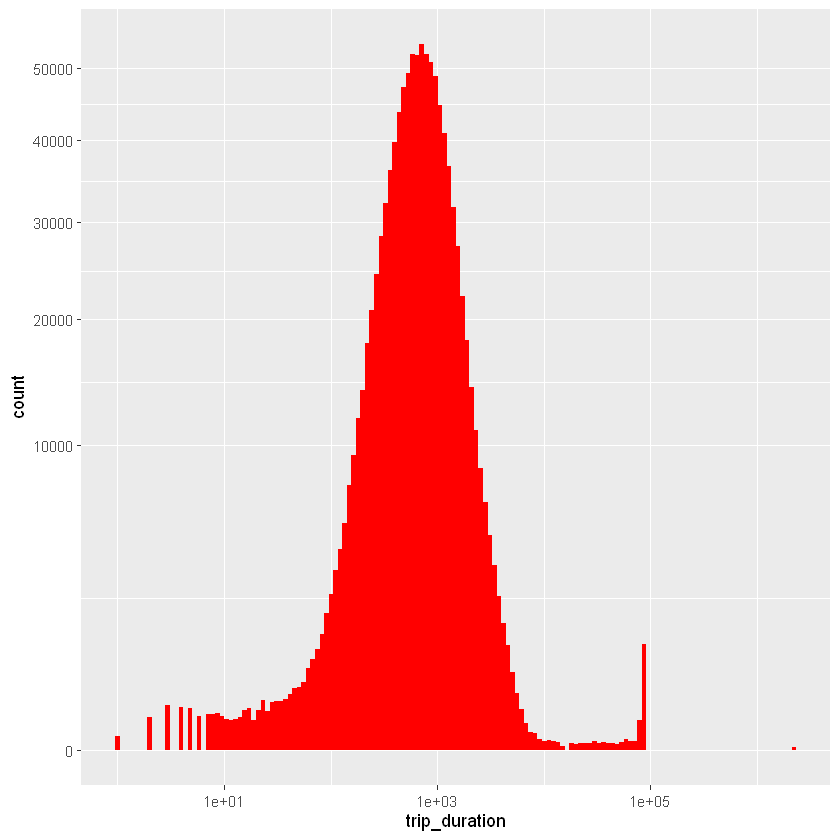

In [16]:
train %>%
  ggplot(aes(trip_duration)) +
  geom_histogram(fill = "red", bins = 150) +
  scale_x_log10() +
  scale_y_sqrt()

most of the trips durations are around 1000 seconds  
and the trips are skewed to the right (notice the logarithmic scale on x-axis)  
there is also some trips with zero durations, These are outliers, cleaning the data from them might increase the model performance  
and we see a prominent in trip duration around 27 hours and one trip with even a higher duration, so we are gonna have a close look at these long trips.

train %>%
  arrange(desc(trip_duration)) %>%
  select(trip_duration, pickup_datetime, everything()) %>%
  head(10)

non of these long trips makes sense, most of these outliers have the vendor 2  
decision : to remove the trips with a really high trip duration no one would stay in a taxi for a day or even half a day  
but we can filter with more than 20 hours or something in that average just to be safe

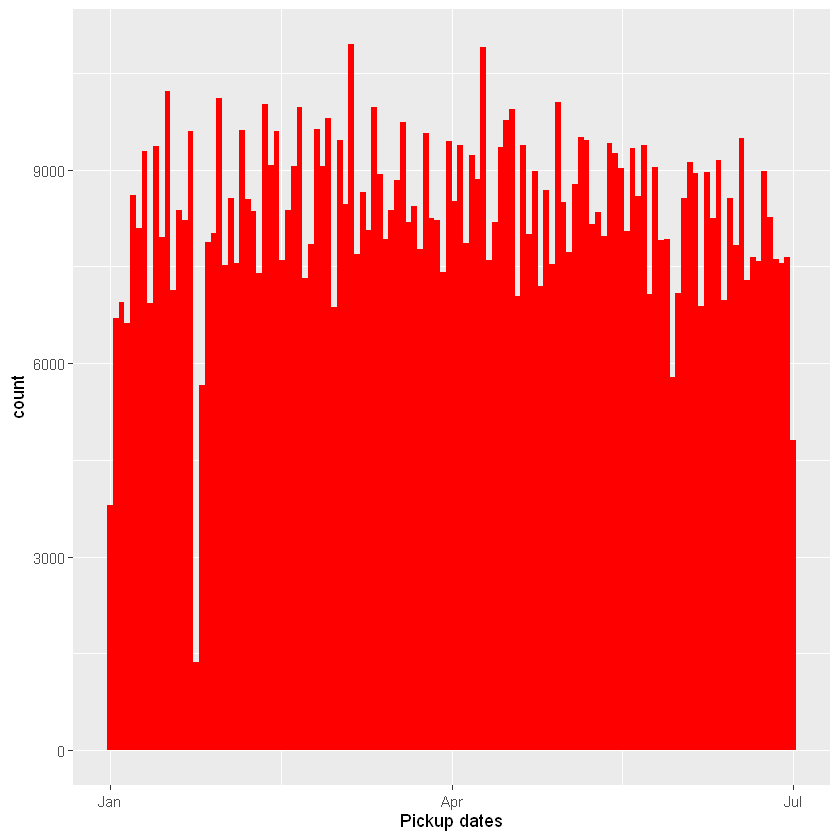

In [17]:
p1 <- train %>%
  ggplot(aes(pickup_datetime)) +
  geom_histogram(fill = "red", bins = 120) +
  labs(x = "Pickup dates")

layout <- matrix(c(1),1,1,byrow=FALSE)
multiplot(p1, layout=layout)
options(repr.plot.width=15, repr.plot.height=7)

there's a prominent drop at late jan and this is attributed to the blizzard happened in new york in that date.  
Decision : considering the blizzard in our dataset to be able to predict in that date and other dates with blizzard.  
Even after considering the blizzard we still want another feature to explain the ups and downs in the plot,It might  
be due to the difference activity from hour to another or from another weekday to another or from month to another so we  
are going to plot a graph that displays the relation between every feature and the number of trips

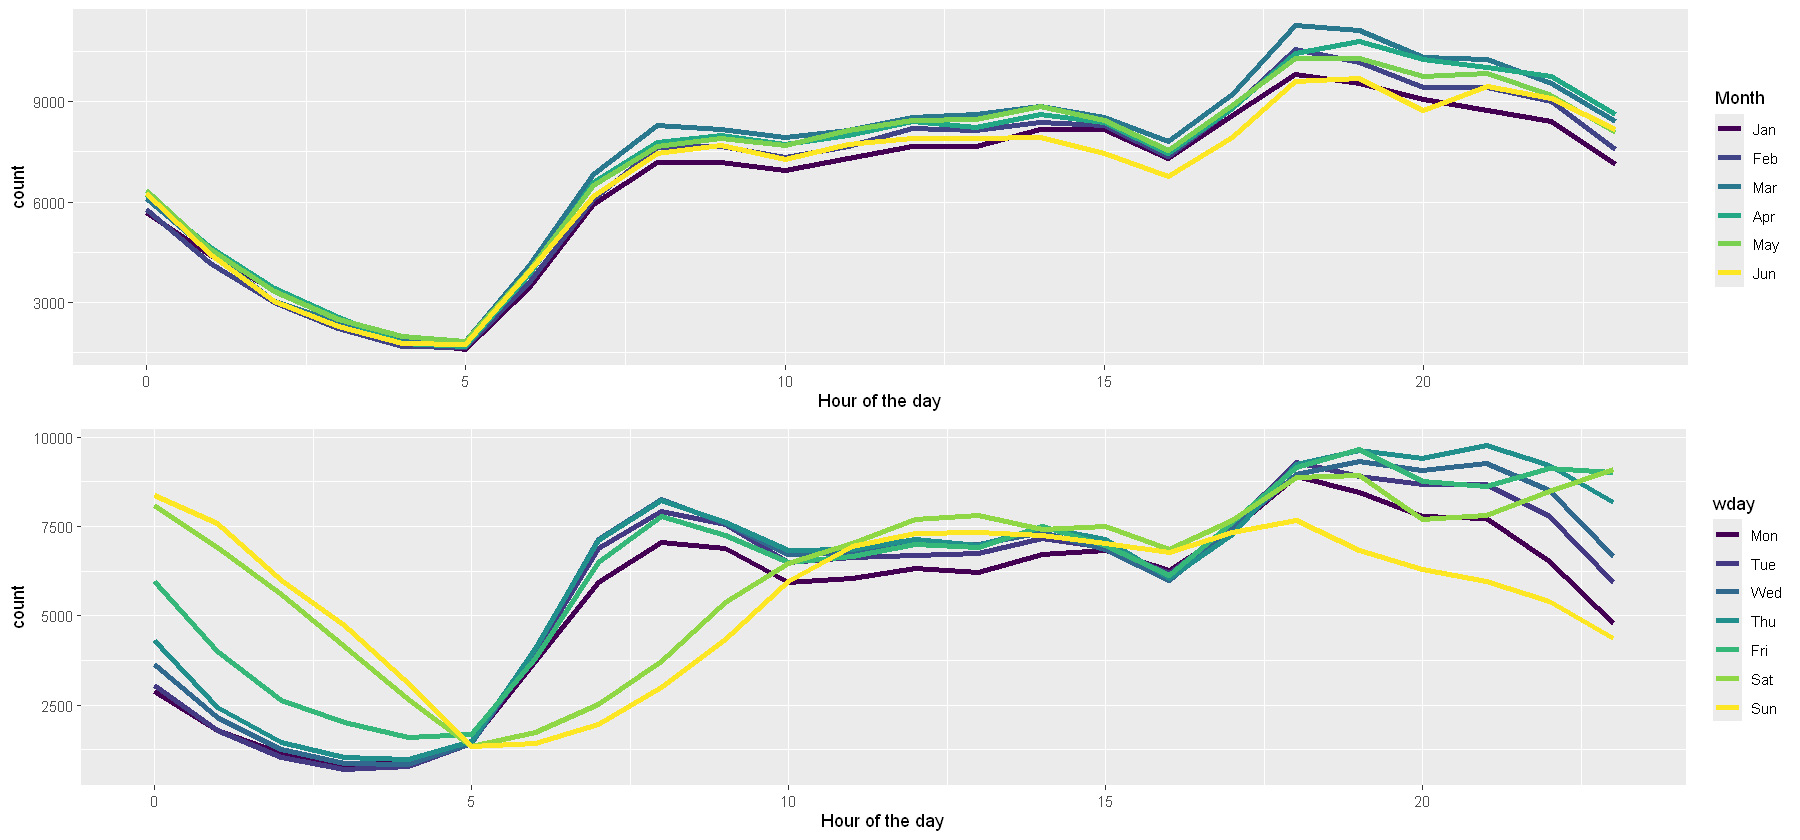

In [18]:
p1 <- train %>%
  mutate(hpick = hour(pickup_datetime),
         Month = factor(month(pickup_datetime, label = TRUE))) %>%
  group_by(hpick, Month) %>%
  count() %>%
  ggplot(aes(hpick, n, color = Month)) +
  geom_line(linewidth = 1.5) +
  labs(x = "Hour of the day", y = "count")

p2 <- train %>%
  mutate(hpick = hour(pickup_datetime),
         wday = factor(wday(pickup_datetime, label = TRUE, week_start = 1))) %>%
  group_by(hpick, wday) %>%
  count() %>%
  ggplot(aes(hpick, n, color = wday)) +
  geom_line(linewidth = 1.5) +
  labs(x = "Hour of the day", y = "count")

layout <- matrix(c(1,2),2,1,byrow=FALSE)
multiplot(p1, p2, layout=layout)

seems like the number of trips falls down from midnight to the dawn which makes sense and then trips increases during the day.   
jun seems to have the least number of trips while mar seems to have the most trips.  
Sunday and saturday have less trips than other weekdays (the weekend days in NY) but from midnight to the dawn weekend days  
have the the most trips  
Conclusion : different weekdays and different month have different trip count  
Decision : it is smart consider these features in our dataset  
  
After checking the target and pickup dates let's check the longitudes and latitudes zone that contain most  
of our data just to avoid the outliers and then graph to get a better insight for coordinates and trip counts relation

In [19]:
quantile(train$pickup_longitude, probs = c(0.01, 0.99), na.rm = TRUE)

1%       99% 
-74.01433 -73.78222

In [20]:
quantile(train$pickup_latitude, probs = c(0.01, 0.99), na.rm = TRUE)

1%      99% 
40.64482 40.80663

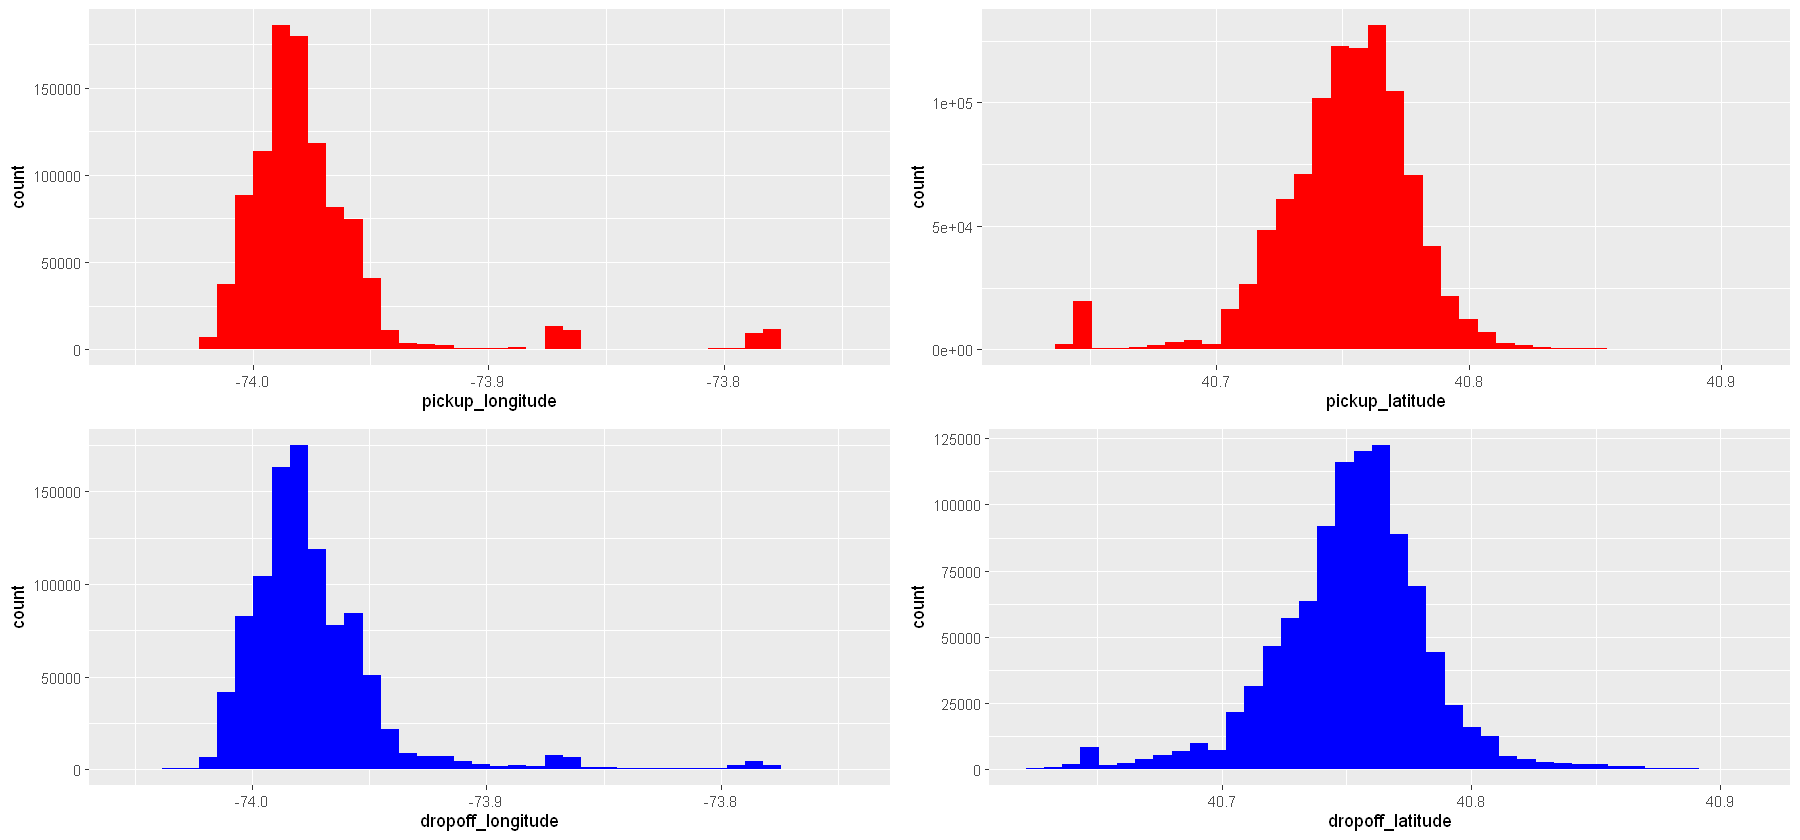

In [21]:
p1 <- train %>%
  filter(pickup_longitude > -74.05 & pickup_longitude < -73.747) %>%
  ggplot(aes(pickup_longitude)) +
  geom_histogram(fill = "red", bins = 40)

p2 <- train %>%
  filter(dropoff_longitude > -74.05 & dropoff_longitude < -73.747) %>%
  ggplot(aes(dropoff_longitude)) +
  geom_histogram(fill = "blue", bins = 40)

p3 <- train %>%
  filter(pickup_latitude > 40.625 & pickup_latitude < 40.91) %>%
  ggplot(aes(pickup_latitude)) +
  geom_histogram(fill = "red", bins = 40)

p4 <- train %>%
  filter(dropoff_latitude > 40.625 & dropoff_latitude < 40.91) %>%
  ggplot(aes(dropoff_latitude)) +
  geom_histogram(fill = "blue", bins = 40)

layout <- matrix(c(1,2,3,4),2,2,byrow=FALSE)
multiplot(p1, p2, p3, p4, layout=layout)

we can see small prominences in every graph which indicate that there's a higher activity  
in those places so what is the factor or the place causing that ?    
if we look up these coordinates we will find out two airports (John F. Kennedy International Airport and LaGuardia Airport)  
trips for airports are usually long so we need to consider if our trip is from or to the one of these two airports  
other than that in our distribution we have a pretty normal distribution but remember that those graphs don't represent  
outliers coordinates so we can have a look at them before moving on to vendor_id feature  

In [22]:
train %>%
  arrange(pickup_latitude) %>%
  select(pickup_latitude, pickup_longitude) %>%
  head(5)

pickup_latitude,pickup_longitude
<dbl>,<dbl>
34.35970,-65.84839
35.08153,-71.79990
35.31031,-72.07433
36.02930,-77.44075
37.38938,-121.93334


In [23]:
train %>%
  arrange(pickup_latitude) %>%
  select(pickup_latitude, pickup_longitude) %>%
  tail(5)

pickup_latitude,pickup_longitude
<dbl>,<dbl>
43.13965,-72.59102
43.48689,-74.19514
43.91176,-71.88165
44.37194,-66.97216
51.88108,-72.80967


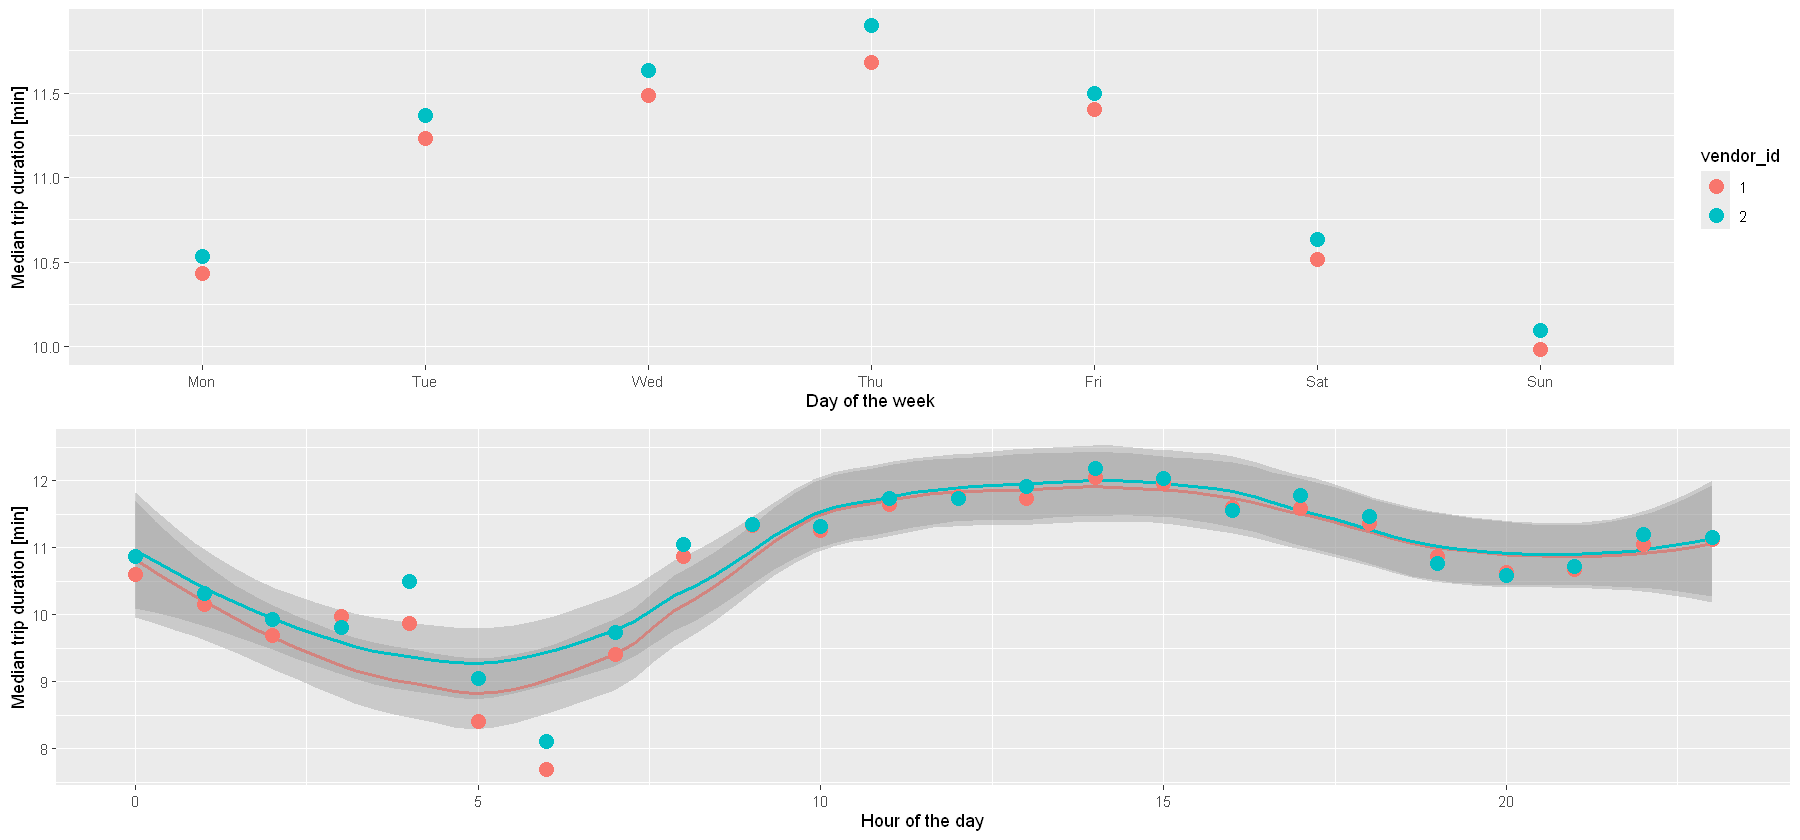

In [24]:
invisible(capture.output(suppressMessages(suppressWarnings({
p1 <- train %>%
  mutate(wday = wday(pickup_datetime, label = TRUE, week_start = 1)) %>%
  group_by(wday, vendor_id) %>%
  summarise(median_duration = median(trip_duration)/60, .groups = "drop") %>%
  ggplot(aes(wday, median_duration, color = vendor_id)) +
  geom_point(size = 4) +
  labs(x = "Day of the week", y = "Median trip duration [min]")

p2 <- train %>%
  mutate(hpick = hour(pickup_datetime)) %>%
  group_by(hpick, vendor_id) %>%
  summarise(median_duration = median(trip_duration)/60, .groups = "drop") %>%
  ggplot(aes(hpick, median_duration, color = vendor_id)) +
  geom_smooth(method = "loess", span = 1/2) +
  geom_point(size = 4) +
  labs(x = "Hour of the day", y = "Median trip duration [min]") +
  theme(legend.position = "none");

layout <- matrix(c(1,2),2,1,byrow=FALSE);
multiplot(p1, p2, layout=layout);
}))))

seems like our vendors behave the same during the week and the day  
and vendor 2 has more median duration than vendor 1 almost all the time  
since there's no real difference in behavior with time let's check if there is with the number of passengers

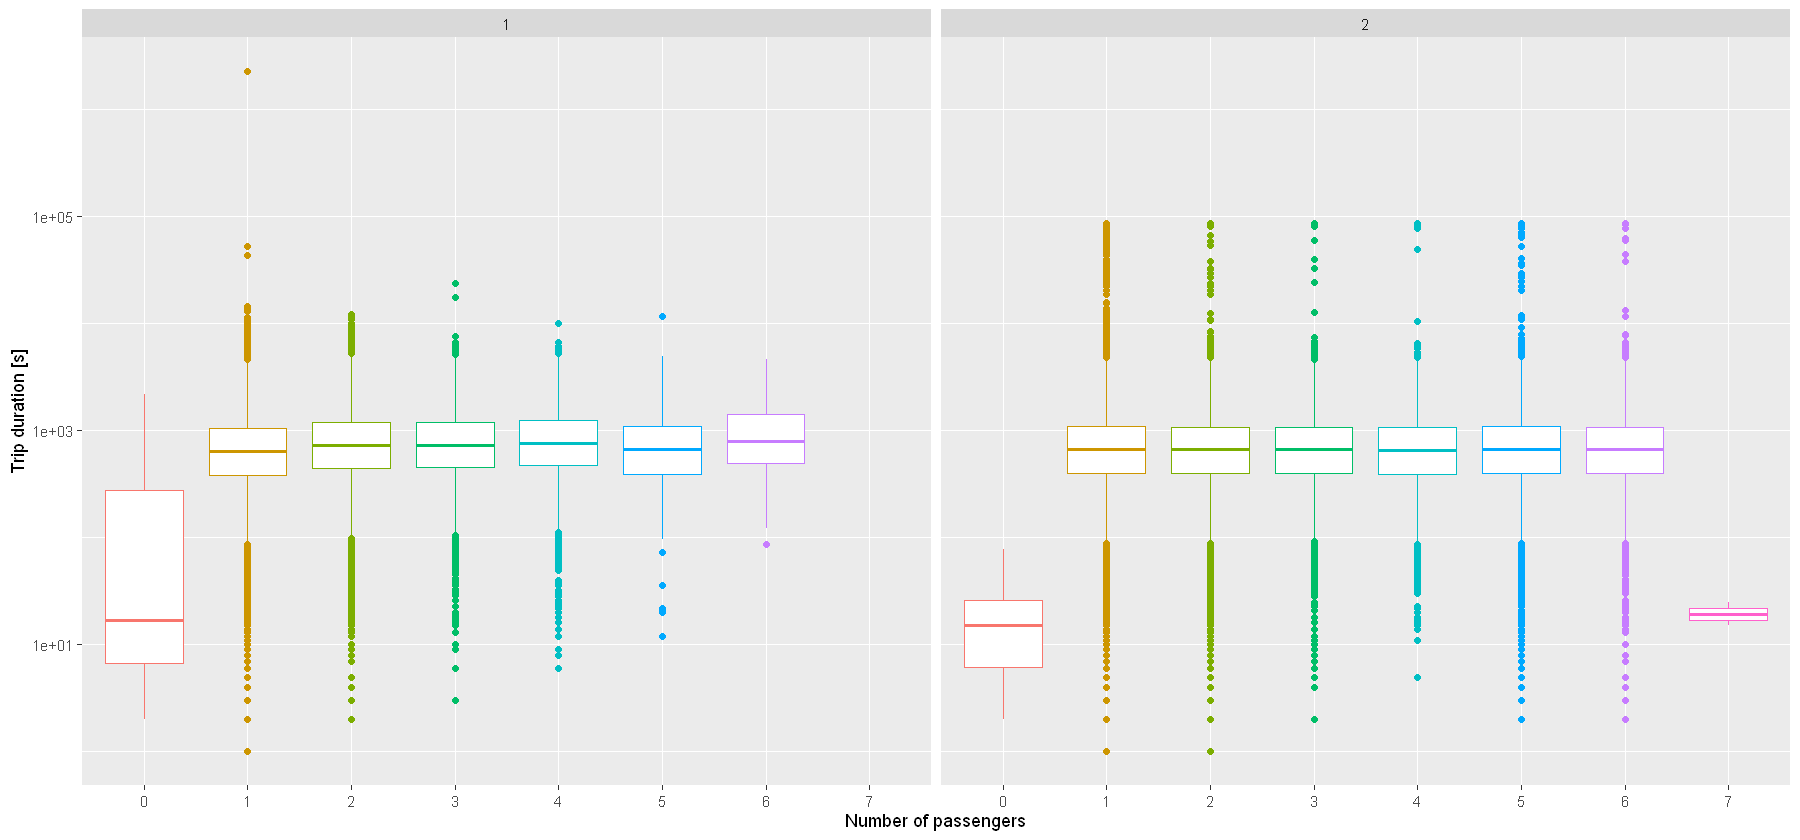

In [25]:
train %>%
  ggplot(aes(passenger_count, trip_duration, color = passenger_count)) +
  geom_boxplot() +
  scale_y_log10() +
  theme(legend.position = "none") +
  facet_wrap(~ vendor_id) +
  labs(y = "Trip duration [s]", x = "Number of passengers")

again both vendors behave the same with different number of passengers only in extreme number of passengers  
which are few in our data  
another conclusion is that number of passengers doesn't really have a relation with the duration time in the most  
common popular passenger counts 
since the 2 vendors still behave the same let's check their trip durations

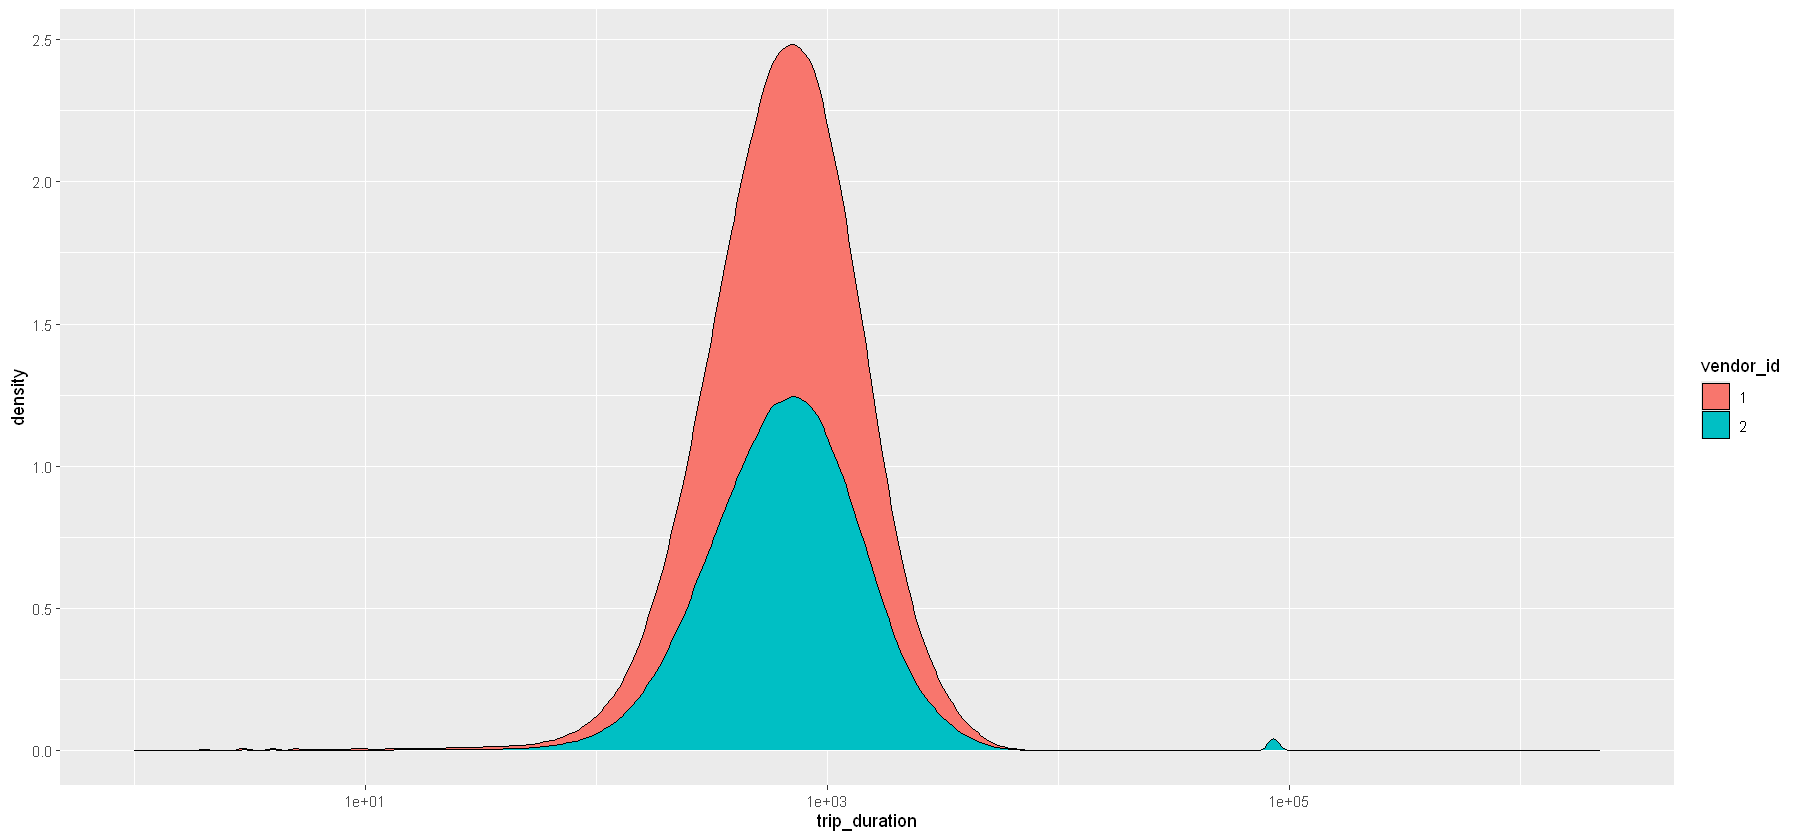

In [26]:
train %>%
  ggplot(aes(trip_duration, fill = vendor_id)) +
  geom_density(position = "stack") +
  scale_x_log10()

both vendors have the the same median trip duration with vendor 2 having the more skewed values  
which we noticed from earlier  
vendor_id are still a good indicator for trip duration but there's no need to make an interaction  
with vendor_id feature and another one  
and now let's check the next feature 'Store_and_fwd_flag'

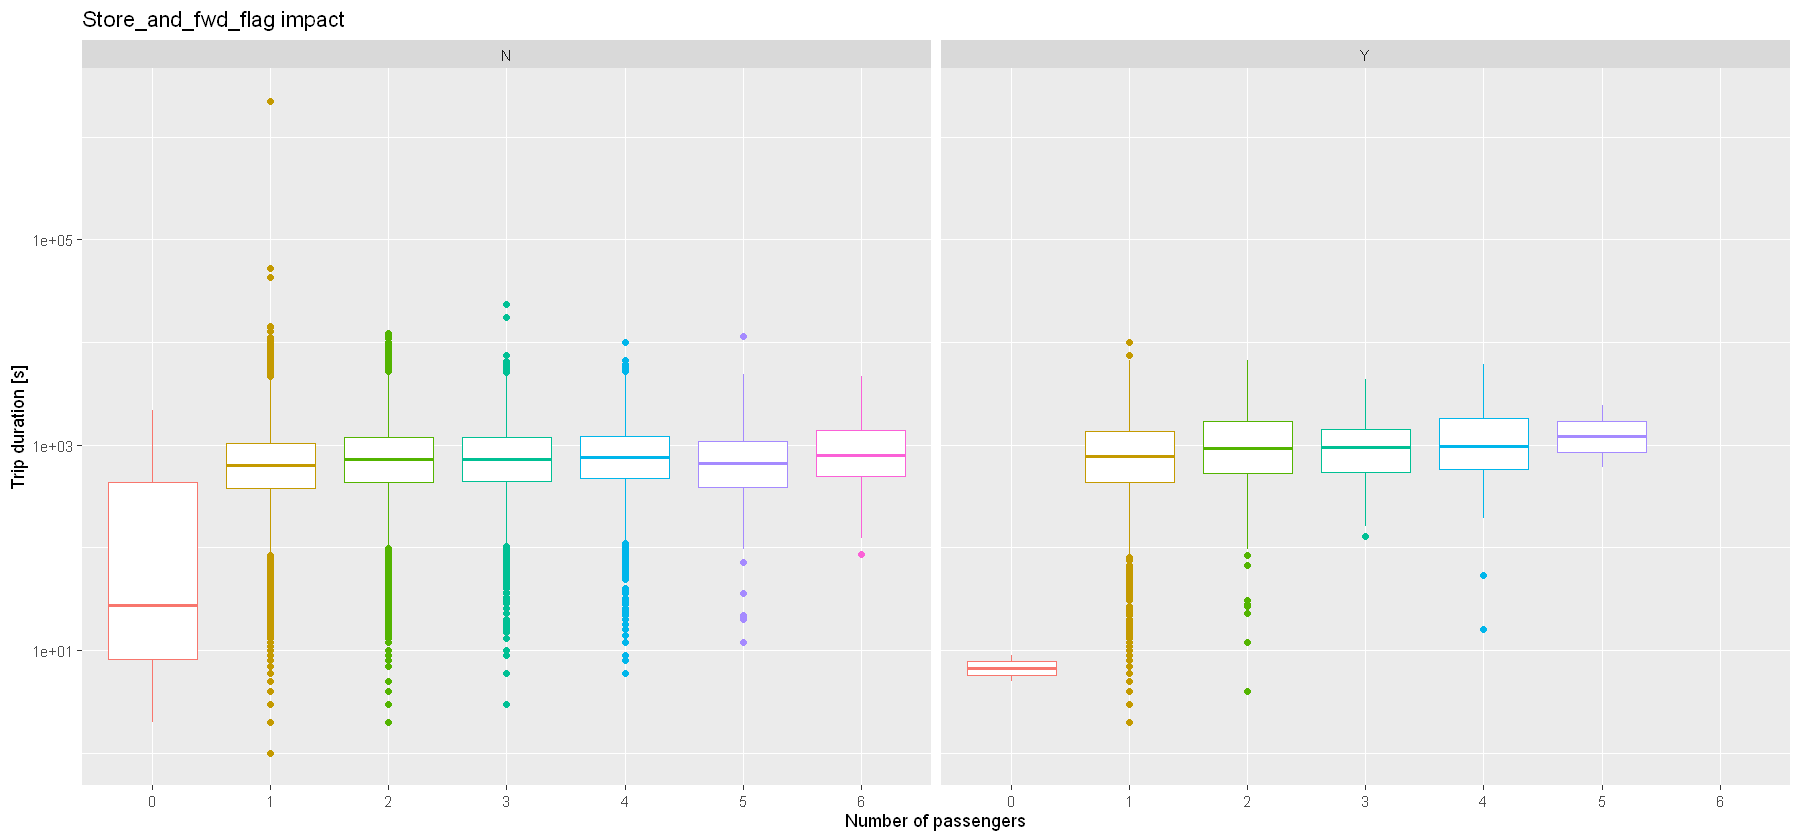

In [27]:
train %>%
  filter(vendor_id == 1) %>%
  ggplot(aes(passenger_count, trip_duration, color = passenger_count)) +
  geom_boxplot() +
  scale_y_log10() +
  facet_wrap(~ store_and_fwd_flag) +
  theme(legend.position = "none") +
  labs(y = "Trip duration [s]", x = "Number of passengers") +
  ggtitle("Store_and_fwd_flag impact")


again same behavior from both N and Y and since we don't expect this feature to have a huge impact anyway   
we will start applying the decisions we made such as having the airport trips in our data, getting the weekday feature and blizzard feature  
and generate some new features as getting the bear of the trip or the speed which could help us in cleaning our data  
even thought we won't be able to use it as a feature since we won't have the duration in the test  
note that : we created bearin_sin & bearing_cos for a better representing values

In [28]:
jfk_coord <- tibble(lon = -73.778889, lat = 40.639722)
la_guardia_coord <- tibble(lon = -73.872611, lat = 40.77725)

pick_coord <- train %>%
  select(pickup_longitude, pickup_latitude)
drop_coord <- train %>%
  select(dropoff_longitude, dropoff_latitude)
train$dist <- distCosine(pick_coord, drop_coord)

train$bearing = bearing(pick_coord, drop_coord)
train$bearing_sin <- sin(train$bearing * pi / 180)
train$bearing_cos <- cos(train$bearing * pi / 180)

train$jfk_dist_pick <- distCosine(pick_coord, jfk_coord)
train$jfk_dist_drop <- distCosine(drop_coord, jfk_coord)
train$lg_dist_pick <- distCosine(pick_coord, la_guardia_coord)
train$lg_dist_drop <- distCosine(drop_coord, la_guardia_coord)

train <- train %>%
  mutate(speed = dist/trip_duration*3.6,
         date = date(pickup_datetime),
         month = month(pickup_datetime, label = TRUE),
         wday = wday(pickup_datetime, label = TRUE, week_start = 1),
         hour = hour(pickup_datetime),
         work = (hour %in% seq(8,18)) & (wday %in% c("Mon","Tues","Wed","Thurs","Fri")),
         jfk_trip = (jfk_dist_pick < 2e3) | (jfk_dist_drop < 2e3),
         lg_trip = (lg_dist_pick < 2e3) | (lg_dist_drop < 2e3),
         blizzard = !( (date < ymd("2016-01-22") | (date > ymd("2016-01-29"))) )
         )

In [29]:
jfk_coord <- tibble(lon = -73.778889, lat = 40.639722)
la_guardia_coord <- tibble(lon = -73.872611, lat = 40.77725)

pick_coord <- val %>%
  select(pickup_longitude, pickup_latitude)
drop_coord <- val %>%
  select(dropoff_longitude, dropoff_latitude)
val$dist <- distCosine(pick_coord, drop_coord)

val$bearing = bearing(pick_coord, drop_coord)
val$bearing_sin <- sin(val$bearing * pi / 180)
val$bearing_cos <- cos(val$bearing * pi / 180)

val$jfk_dist_pick <- distCosine(pick_coord, jfk_coord)
val$jfk_dist_drop <- distCosine(drop_coord, jfk_coord)
val$lg_dist_pick <- distCosine(pick_coord, la_guardia_coord)
val$lg_dist_drop <- distCosine(drop_coord, la_guardia_coord)

val <- val %>%
  mutate(speed = dist/trip_duration*3.6,
         date = date(pickup_datetime),
         month = month(pickup_datetime, label = TRUE),
         wday = wday(pickup_datetime, label = TRUE, week_start = 1),
         hour = hour(pickup_datetime),
         work = (hour %in% seq(8,18)) & (wday %in% c("Mon","Tues","Wed","Thurs","Fri")),
         jfk_trip = (jfk_dist_pick < 2e3) | (jfk_dist_drop < 2e3),
         lg_trip = (lg_dist_pick < 2e3) | (lg_dist_drop < 2e3),
         blizzard = !( (date < ymd("2016-01-22") | (date > ymd("2016-01-29"))) )
         )

In [30]:
jfk_coord <- tibble(lon = -73.778889, lat = 40.639722)
la_guardia_coord <- tibble(lon = -73.872611, lat = 40.77725)

pick_coord <- test %>%
  select(pickup_longitude, pickup_latitude)
drop_coord <- test %>%
  select(dropoff_longitude, dropoff_latitude)
test$dist <- distCosine(pick_coord, drop_coord)

test$bearing = bearing(pick_coord, drop_coord)
test$bearing_sin <- sin(test$bearing * pi / 180)
test$bearing_cos <- cos(test$bearing * pi / 180)

test$jfk_dist_pick <- distCosine(pick_coord, jfk_coord)
test$jfk_dist_drop <- distCosine(drop_coord, jfk_coord)
test$lg_dist_pick <- distCosine(pick_coord, la_guardia_coord)
test$lg_dist_drop <- distCosine(drop_coord, la_guardia_coord)

test <- test %>%
  mutate(
         date = date(pickup_datetime),
         month = month(pickup_datetime, label = TRUE),
         wday = wday(pickup_datetime, label = TRUE, week_start = 1),
         hour = hour(pickup_datetime),
         work = (hour %in% seq(8,18)) & (wday %in% c("Mon","Tues","Wed","Thurs","Fri")),
         jfk_trip = (jfk_dist_pick < 2e3) | (jfk_dist_drop < 2e3),
         lg_trip = (lg_dist_pick < 2e3) | (lg_dist_drop < 2e3),
         blizzard = !( (date < ymd("2016-01-22") | (date > ymd("2016-01-29"))) )
         )

first we generated dist feature which is intuitive thing to do with the coordinates features  
and now we wanna graph its relation with the duration this feature specially is the most important  
Basically the trip duration should be really depended on its distance 

In [31]:
invisible(capture.output(suppressMessages(suppressWarnings({
set.seed(4321)
train %>%
  sample_n(5e4) %>%
  ggplot(aes(dist, trip_duration)) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "Direct distance [m]", y = "Trip duration [s]")
  print(train)
}))))

distance and duration relation is direct.Also there's some trips with 0 distance which is suspicious to have  
As no one would take a taxi to stay in the same place yes maybe the passenger got in and then changed his mind  
so we aren't going to add a condition to filtering just to be safe
decision : filter all the trips with 0 distances and a minute duration or more  
and now we can have a better look at our data without these outliers

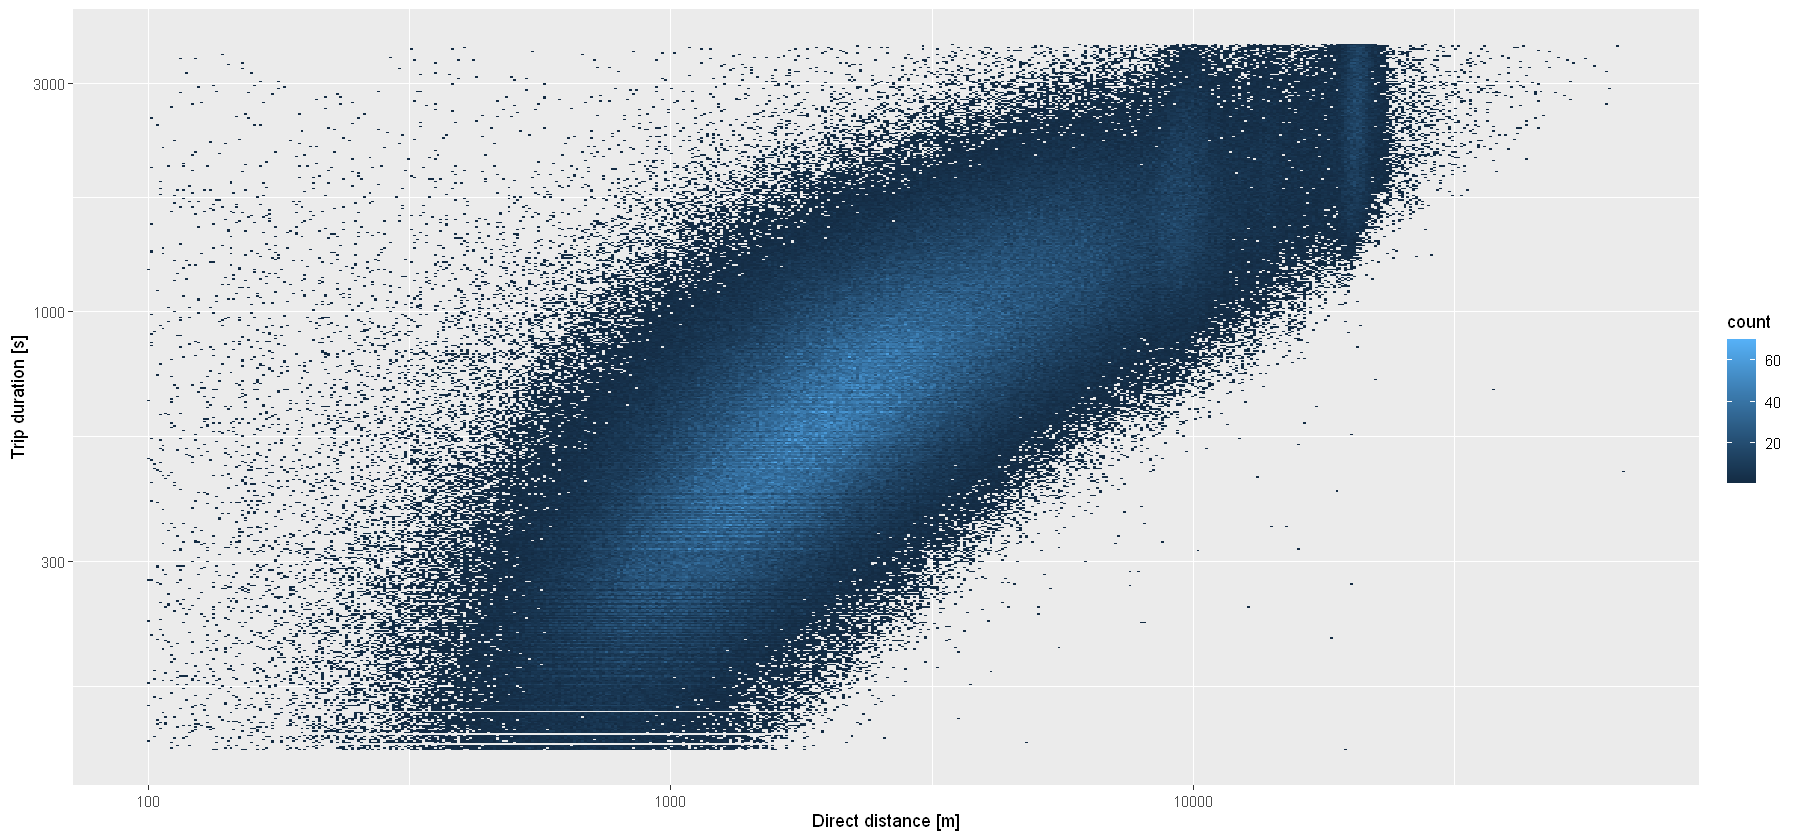

In [32]:
train %>%
  filter(trip_duration < 3600 & trip_duration > 120) %>%
  filter(dist > 100 & dist < 100e3) %>%
  ggplot(aes(dist, trip_duration)) +
  geom_bin2d(bins = c(500,500)) +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "Direct distance [m]", y = "Trip duration [s]")

speed feature can help us clean the data as trips with stupid high speed is an obvious outlier  
or with 0 or close to zero speed as we said before no one would take a taxi to stay in his place  
keep in mind that our distance is the direct distance meaning that our actual speed is higher than  
what our feature tells us

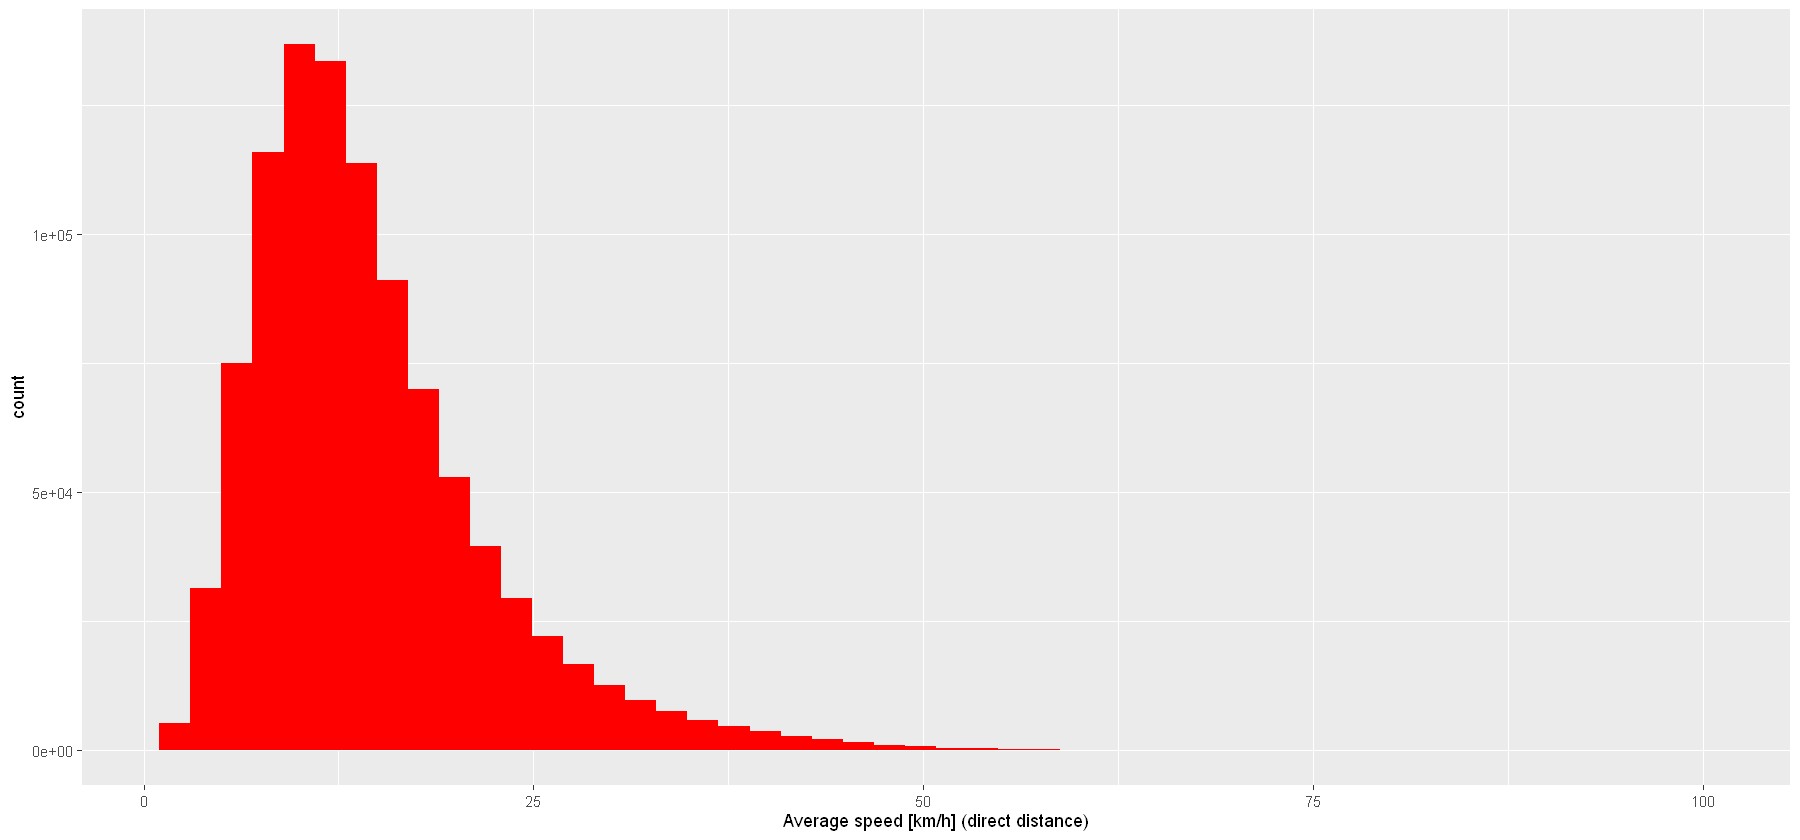

In [33]:
train %>%
  filter(speed > 2 & speed < 1e2) %>%
  ggplot(aes(speed)) +
  geom_histogram(fill = "red", bins = 50) +
  labs(x = "Average speed [km/h] (direct distance)")

the distribution seems logical after filtering the outliers  
not only we can detect outliers with our feature but we can detect different trip durations  
from day to another and from hour to another using our feature as speed should has a negative  
relation with duration for sure

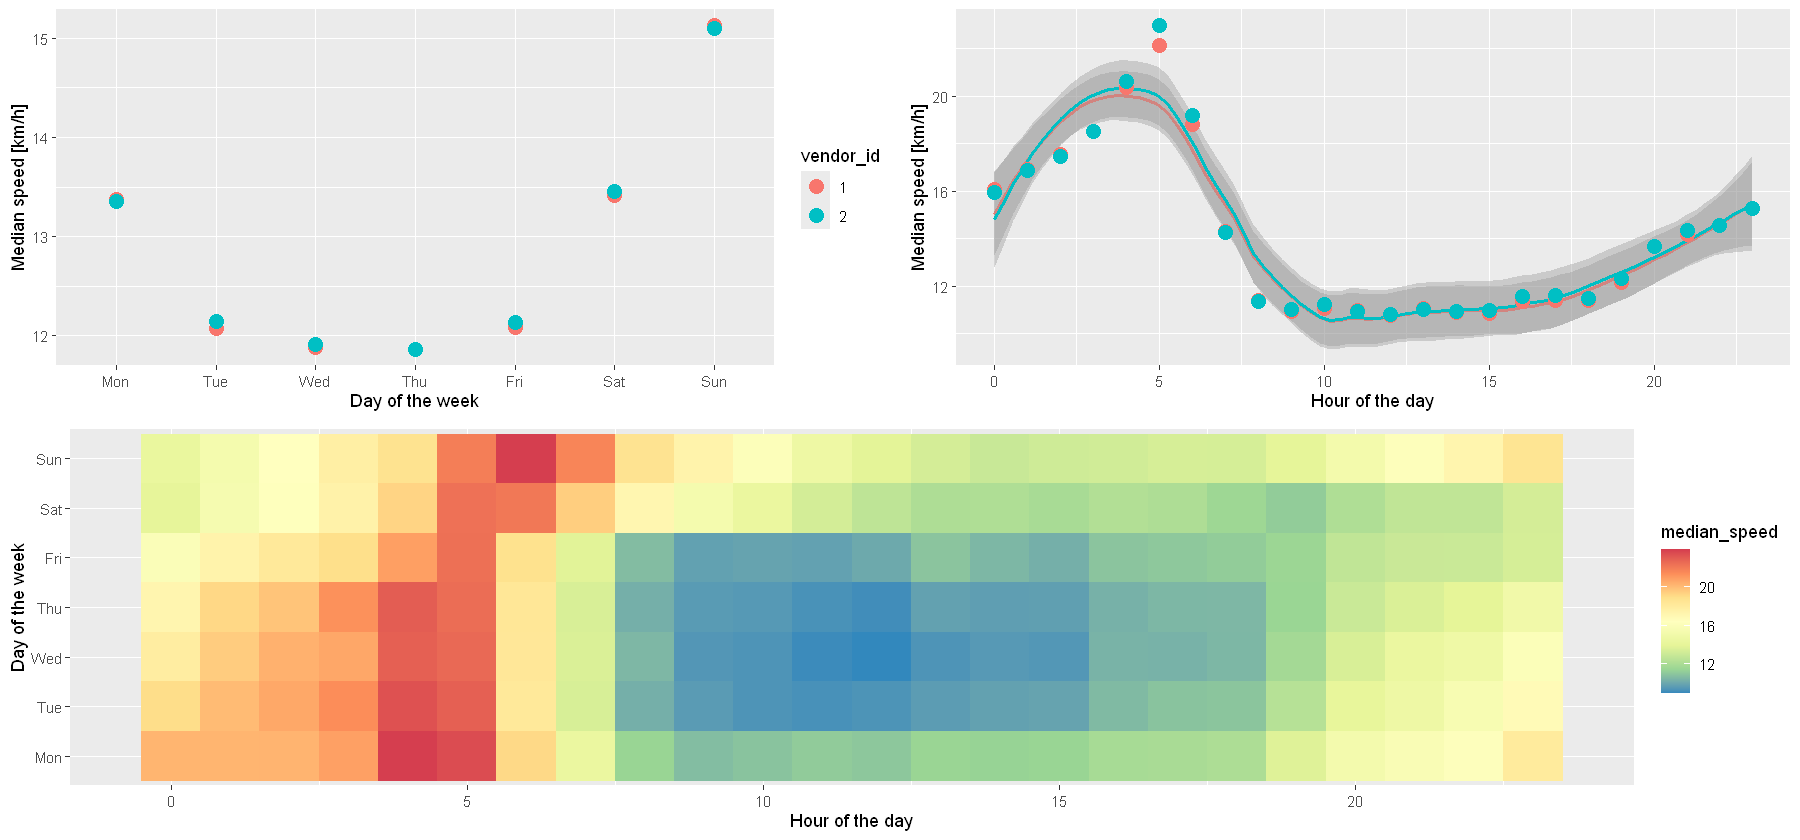

In [34]:
suppressWarnings(
  suppressMessages({
p1 <- train %>%
  group_by(wday, vendor_id) %>%
  summarise(median_speed = median(speed)) %>%
  ggplot(aes(wday, median_speed, color = vendor_id), .groups = "drop") +
  geom_point(size = 4) +
  labs(x = "Day of the week", y = "Median speed [km/h]")

p2 <- train %>%
  group_by(hour, vendor_id) %>%
  summarise(median_speed = median(speed)) %>%
  ggplot(aes(hour, median_speed, color = vendor_id), .groups = "drop")+
  geom_smooth(method = "loess", span = 1/2) +
  geom_point(size = 4) +
  labs(x = "Hour of the day", y = "Median speed [km/h]") +
  theme(legend.position = "none")

p3 <- train %>%
  group_by(wday, hour) %>%
  summarise(median_speed = median(speed), .groups = "drop") %>%
  ggplot(aes(hour, wday, fill = median_speed)) +
  geom_tile() +
  labs(x = "Hour of the day", y = "Day of the week") +
  scale_fill_distiller(palette = "Spectral")

layout <- matrix(c(1,2,3,3),2,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)
})
)

the 2 vendor's speed barely differ  
during the work weekdays and hour the median speed decrease indicating the traffic jam due to  
due to the higher activity and increase at dawn indicating the the low activity in streets  
moving to the next feature 'bearing' and its relation with other features and the target  
but keep in mind the nature of manhattan nature and its streets (the main zone for our data in NY)  
the street network in Manhattan exhibits a zigzag pattern oriented from the northeast to the southwest

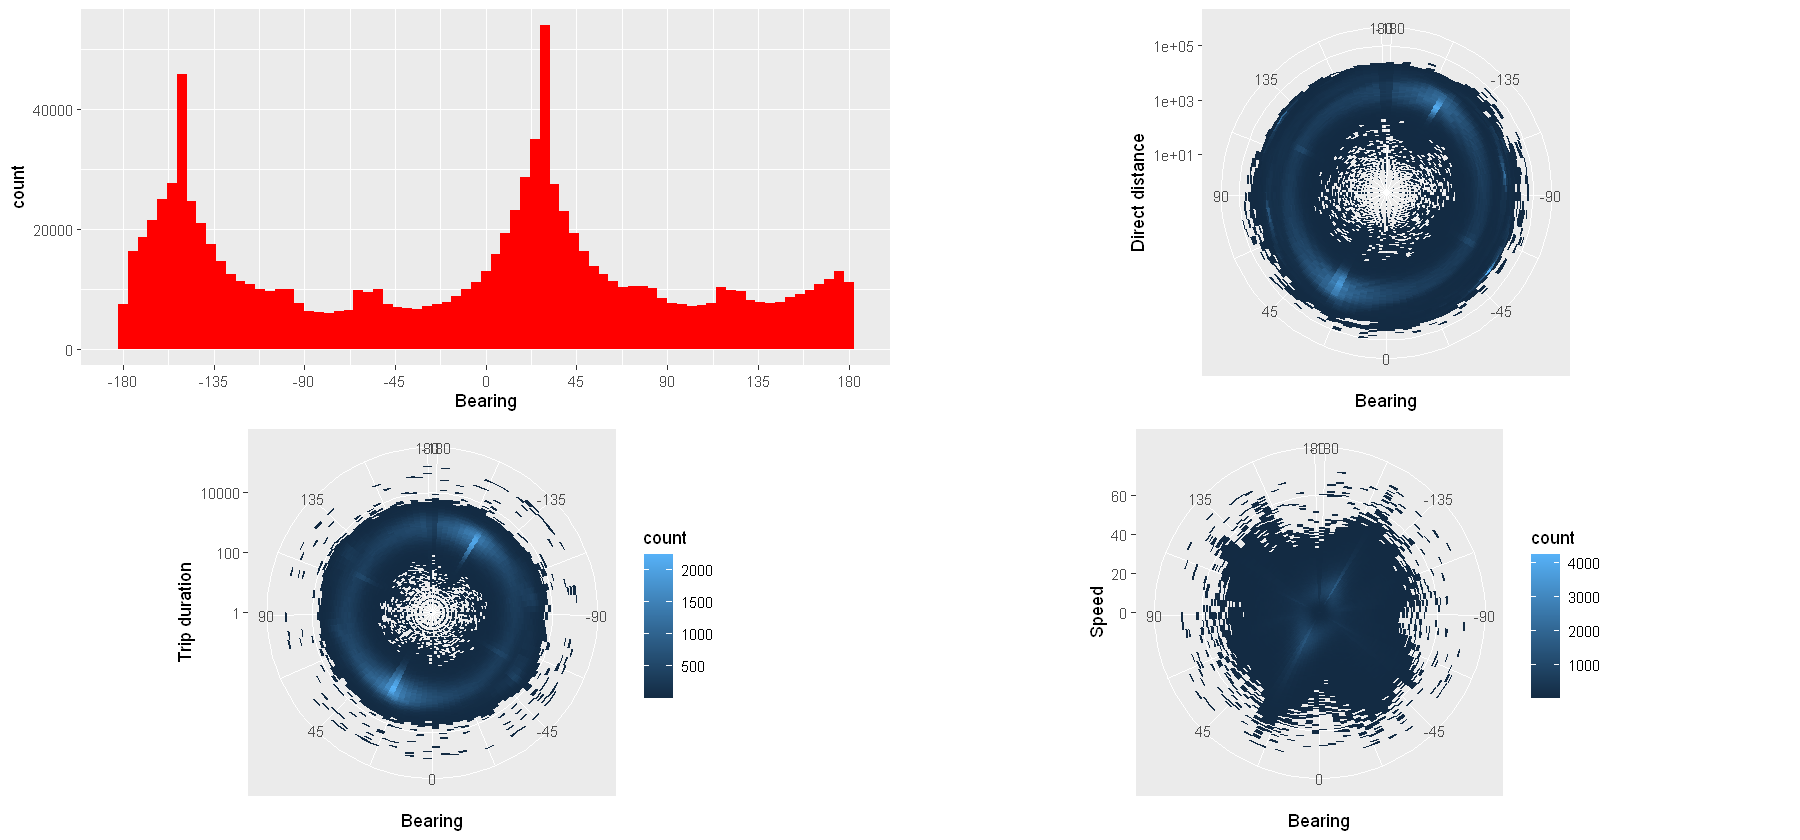

In [35]:
suppressWarnings({
p1 <- train %>%
  filter(dist < 1e5) %>%
  ggplot(aes(bearing)) +
  geom_histogram(fill = "red", bins = 75) +
  scale_x_continuous(breaks = seq(-180, 180, by = 45)) +
  labs(x = "Bearing")

p2 <- train %>%
  filter(dist < 1e5) %>%
  ggplot(aes(bearing, dist)) +
  geom_bin2d(bins = c(100,100)) +
  labs(x = "Bearing", y = "Direct distance") +
  scale_y_log10() +
  theme(legend.position = "none") +
  coord_polar() +
  scale_x_continuous(breaks = seq(-180, 180, by = 45))

p3 <- train %>%
  filter(trip_duration < 3600*22) %>%
  filter(dist < 1e5) %>%
  ggplot(aes(bearing, trip_duration)) +
  geom_bin2d(bins = c(100,100)) +
  scale_y_log10() +
  labs(x = "Bearing", y = "Trip duration") +
  coord_polar() +
  scale_x_continuous(breaks = seq(-180, 180, by = 45))

p4 <- train %>%
  filter(speed < 75 & dist < 1e5) %>%
  ggplot(aes(bearing, speed)) +
  geom_bin2d(bins = c(100,100)) +
  labs(x = "Bearing", y = "Speed") +
  coord_polar() +
  scale_x_continuous(breaks = seq(-180, 180, by = 45))

layout <- matrix(c(1,2,3,4),2,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)
})

the most bearing is north east and south west as expected  
and even though the meanings in our graphs there's no Feature engineer decisions to be taken based on that graph  
and now moving on to the airports features  
we can display the distances from the airports for both pickups and dropoffs  
we defined earlier the airport trip is the trip with pickup or dropoff less than 2km from the airport  

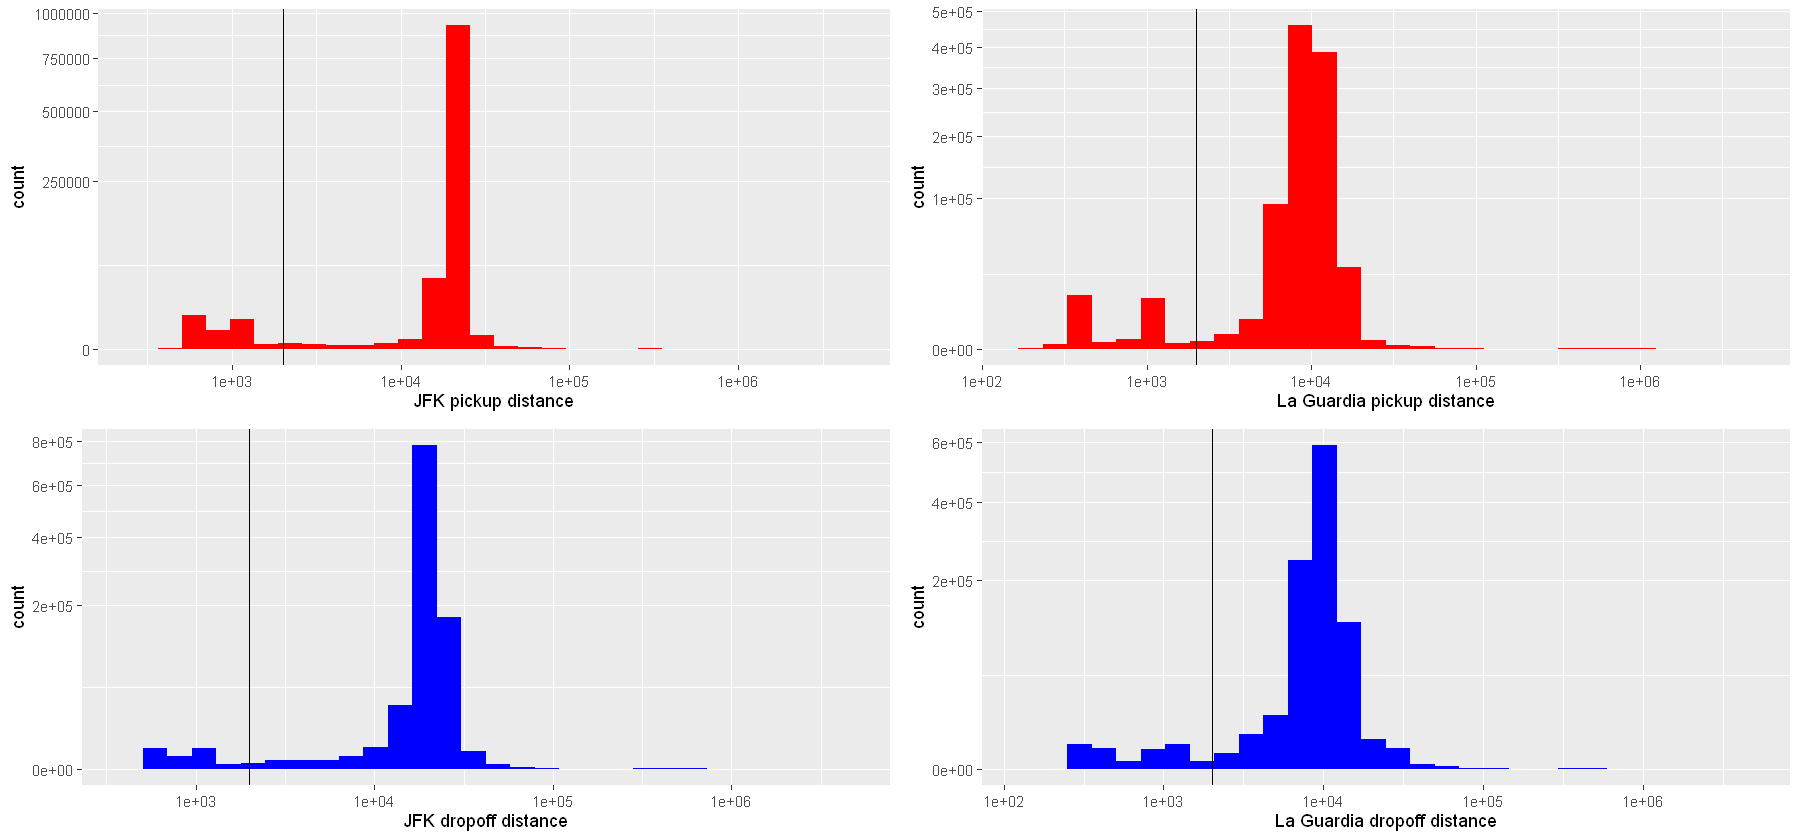

In [36]:
p1 <- train %>%
  ggplot(aes(jfk_dist_pick)) +
  geom_histogram(bins = 30, fill = "red") +
  scale_x_log10() +
  scale_y_sqrt() +
  geom_vline(xintercept = 2e3) +
  labs(x = "JFK pickup distance")

p2 <- train %>%
  ggplot(aes(jfk_dist_drop)) +
  geom_histogram(bins = 30, fill = "blue") +
  scale_x_log10() +
  scale_y_sqrt() +
  geom_vline(xintercept = 2e3) +
  labs(x = "JFK dropoff distance")

p3 <- train %>%
  ggplot(aes(lg_dist_pick)) +
  geom_histogram(bins = 30, fill = "red") +
  scale_x_log10() +
  scale_y_sqrt() +
  geom_vline(xintercept = 2e3) +
  labs(x = "La Guardia pickup distance")

p4 <- train %>%
  ggplot(aes(lg_dist_drop)) +
  geom_histogram(bins = 30, fill = "blue") +
  scale_x_log10() +
  scale_y_sqrt() +
  geom_vline(xintercept = 2e3) +
  labs(x = "La Guardia dropoff distance")

layout <- matrix(c(1,2,3,4),2,2,byrow=FALSE)
multiplot(p1, p2, p3, p4, layout=layout)

seems like our theory is right and there's a higher trips near the 2 airports  
so do airport trips really take higher time because if not then our feature is useless

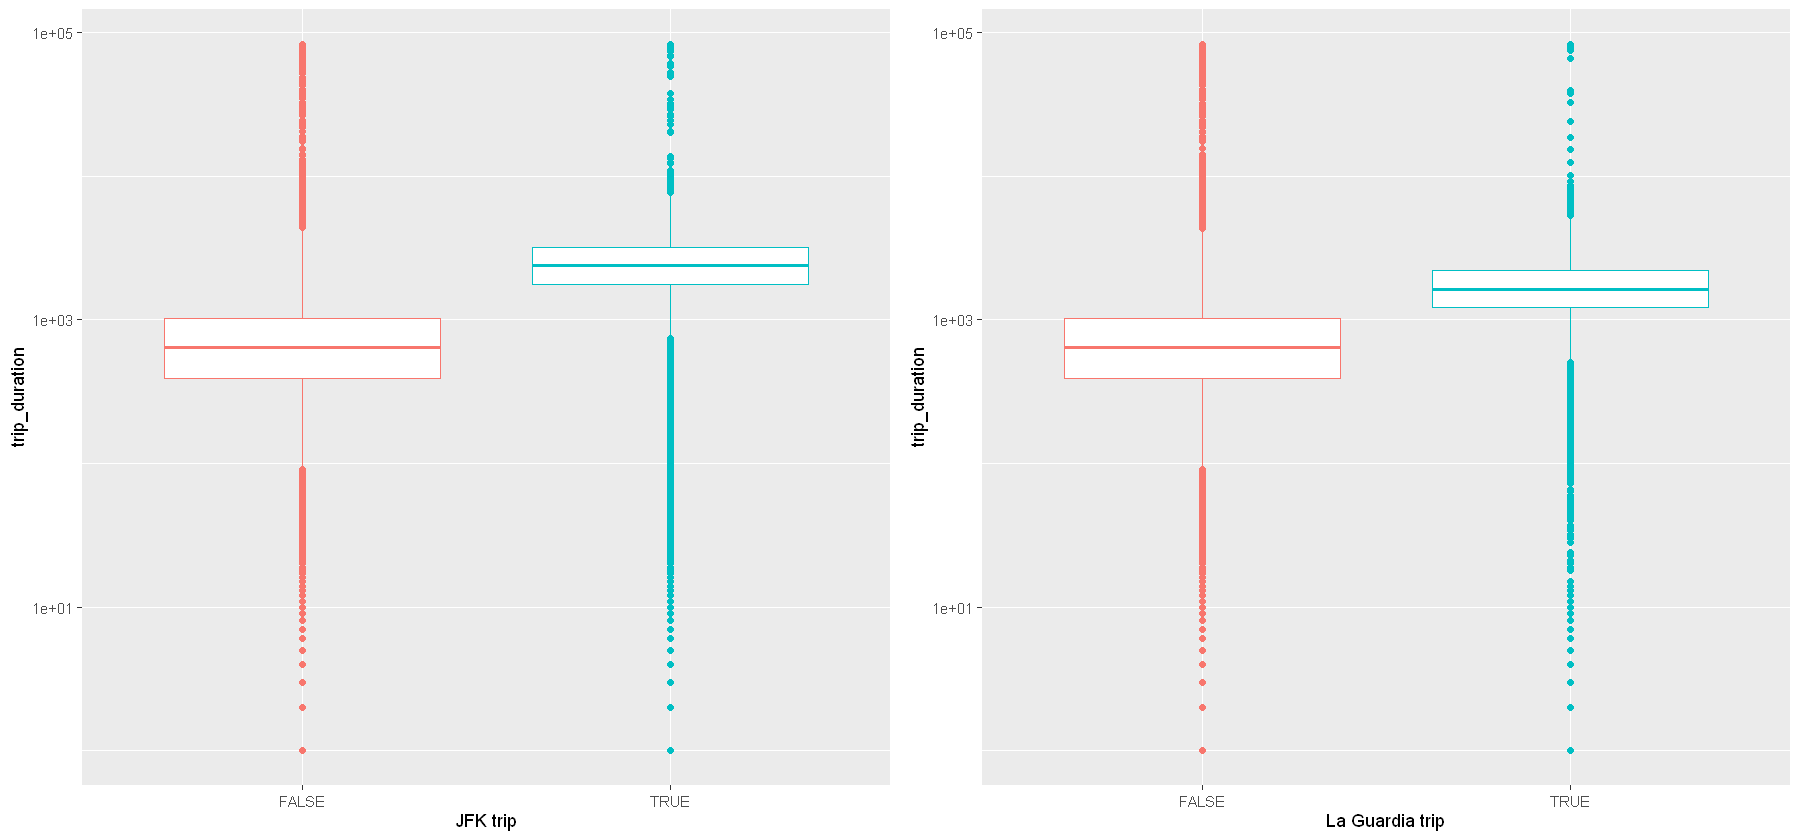

In [37]:
p1 <- train %>%
  filter(trip_duration < 23*3600) %>%
  ggplot(aes(jfk_trip, trip_duration, color = jfk_trip)) +
  geom_boxplot() +
  scale_y_log10() +
  theme(legend.position = "none") +
  labs(x = "JFK trip")

p2 <- train %>%
  filter(trip_duration < 23*3600) %>%
  ggplot(aes(lg_trip, trip_duration, color = lg_trip)) +
  geom_boxplot() +
  scale_y_log10() +
  theme(legend.position = "none") +
  labs(x = "La Guardia trip")

layout <- matrix(c(1,2),1,2,byrow=FALSE)
multiplot(p1, p2, layout=layout)

when the trip is an airport trip it indeed takes more time 


now we are ready to clean our data applying decisions we made earlier  
but we can't do the same to our test because it should be the indicator for a good generalization

In [38]:
train <- train %>%
  filter(trip_duration < 22*3600,
         dist > 0 | (near(dist, 0) & trip_duration < 60),
         jfk_dist_pick < 3e5 & jfk_dist_drop < 3e5,
         trip_duration > 10,
         speed < 100)

In [39]:
val <- val %>%
  filter(trip_duration < 22*3600,
         dist > 0 | (near(dist, 0) & trip_duration < 60),
         jfk_dist_pick < 3e5 & jfk_dist_drop < 3e5,
         trip_duration > 10,
         speed < 100)

In [40]:
summary(train)

      id            vendor_id  pickup_datetime               passenger_count 
 Length:994198      1:463527   Min.   :2016-01-01 00:00:53   1      :704540  
 Class :character   2:530671   1st Qu.:2016-02-17 15:45:57   2      :143173  
 Mode  :character              Median :2016-04-01 15:02:58   5      : 53285  
                               Mean   :2016-04-01 08:55:04   3      : 40788  
                               3rd Qu.:2016-05-15 02:28:27   6      : 33021  
                               Max.   :2016-06-30 23:59:37   4      : 19367  
                                                             (Other):    24  
 pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
 Min.   :-75.46   Min.   :39.80   Min.   :-76.14    Min.   :40.23   
 1st Qu.:-73.99   1st Qu.:40.74   1st Qu.:-73.99    1st Qu.:40.74   
 Median :-73.98   Median :40.75   Median :-73.98    Median :40.75   
 Mean   :-73.97   Mean   :40.75   Mean   :-73.97    Mean   :40.75   
 3rd Qu.:-73.97   3rd Qu.:40.77

now we can start feature engineering by dropping useless columns like id and columns  
that are utilized to the fullest already like pickup_datetime and coordinates features  
and bearing since we already have the sin and cos bearing and speed since we already used it  
in cleaning and we can't have it in test remember we built speed from the target and we can't use that in test

In [41]:
to_drop <- c('id','speed','pickup_datetime','bearing','date',
             'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
             'jfk_dist_pick','jfk_dist_drop','lg_dist_pick','lg_dist_drop')

test_drop <- c('id','pickup_datetime','bearing','date',
    'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
    'jfk_dist_pick','jfk_dist_drop','lg_dist_pick','lg_dist_drop')


if (to_drop[1] %in% colnames(train)) {
  train <- train %>% select(-all_of(to_drop))
  val   <- val   %>% select(-all_of(to_drop))
  test  <- test  %>% select(-all_of(test_drop))
}

hot encoding  

## coding note in R
in R language when you create a feature that is a factor and not just letters or numbers  
by using the function factor() or by using functions that generate a specific type of features  
like month the feature gets what is called level values so like in month feature it has level values  
that has all months even if it isn't in the data and when you hot encode it it encode the level values  
so we need to drop the level values first 

In [42]:
cols <- c("vendor_id", "store_and_fwd_flag", "wday", "jfk_trip", "lg_trip", "blizzard", "work", "month")

train$month <- droplevels(train$month)

train <- fastDummies::dummy_cols(train, 
                                 select_columns = cols, 
                                 remove_first_dummy = FALSE, 
                                 remove_selected_columns = TRUE, 
                                 ignore_na = TRUE)

val <- fastDummies::dummy_cols(val, 
                               select_columns = cols, 
                               remove_first_dummy = FALSE, 
                               remove_selected_columns = TRUE, 
                               ignore_na = TRUE)

test <- fastDummies::dummy_cols(test, 
                                select_columns = cols, 
                                remove_first_dummy = FALSE, 
                                remove_selected_columns = TRUE, 
                                ignore_na = TRUE)

removing features that have their meaning in other features to avoid multicollinearity  
same could be done by remove_first_dummy = TRUE in dummy_cols() function but I choosed to do it manually

In [43]:
hotEncoding_residu <- c('vendor_id_2','store_and_fwd_flag_N','jfk_trip_FALSE',
                        'lg_trip_FALSE','blizzard_FALSE','work_FALSE','wday_Tue','month_May')

if (hotEncoding_residu[1] %in% colnames(train)) {
  train <- train %>% select(-all_of(hotEncoding_residu))
  val   <- val   %>% select(-all_of(hotEncoding_residu))
  test  <- test  %>% select(-all_of(hotEncoding_residu))
}

taking the log for our target and boxcox for our regressed features for a better model performance

In [44]:
suppressPackageStartupMessages({ 
library('MASS'); # boxcox transformation (used)
library('car'); # boxcox transformation (used)
})

train$trip_duration <- log1p(train$trip_duration)
val$trip_duration   <- log1p(val$trip_duration)
test$trip_duration  <- log1p(test$trip_duration)

bc <- powerTransform(train$dist + 1) 
lambda_dist <- bc$lambda

train$dist <- ((train$dist + 1)^lambda_dist - 1)/lambda_dist 
val$dist <- ((val$dist + 1)^lambda_dist - 1)/lambda_dist
test$dist <- ((test$dist + 1)^lambda_dist - 1)/lambda_dist


double check if there's a column in train that is missing in test and the other way around  
and if so just adjust test to match train (safety check)

In [45]:
if (ncol(train) == ncol(val)) {
  print("Number of columns is equal")
} else {
  print("Number of columns differs")
  print("train columns:")
  print(colnames(train))
  print("val columns:")
  print(colnames(val))
  
  missing_cols <- setdiff(colnames(train), colnames(val))
  for (col in missing_cols) {
    val[[col]] <- 0
  }
  
  val <- val[, colnames(train), drop=FALSE]
}

[1] "Number of columns differs"
[1] "train columns:"
 [1] "passenger_count"      "trip_duration"        "dist"                
 [4] "bearing_sin"          "bearing_cos"          "hour"                
 [7] "vendor_id_1"          "store_and_fwd_flag_Y" "wday_Mon"            
[10] "wday_Wed"             "wday_Thu"             "wday_Fri"            
[13] "wday_Sat"             "wday_Sun"             "jfk_trip_TRUE"       
[16] "lg_trip_TRUE"         "blizzard_TRUE"        "work_TRUE"           
[19] "month_Jan"            "month_Feb"            "month_Mar"           
[22] "month_Apr"            "month_Jun"           
[1] "val columns:"
 [1] "passenger_count"      "trip_duration"        "dist"                
 [4] "bearing_sin"          "bearing_cos"          "hour"                
 [7] "vendor_id_1"          "store_and_fwd_flag_Y" "wday_Mon"            
[10] "wday_Wed"             "wday_Thu"             "wday_Fri"            
[13] "wday_Sat"             "wday_Sun"             "jfk_trip_TR

In [46]:
if (ncol(train) == ncol(test)) {
  print("Number of columns is equal")
} else {
  print("Number of columns differs")
  print("train columns:")
  print(colnames(train))
  print("test columns:")
  print(colnames(test))
  
  missing_cols <- setdiff(colnames(train), colnames(test))
  for (col in missing_cols) {
    test[[col]] <- 0
  }
  
  test <- test[, colnames(train), drop = FALSE]
}

[1] "Number of columns differs"
[1] "train columns:"
 [1] "passenger_count"      "trip_duration"        "dist"                
 [4] "bearing_sin"          "bearing_cos"          "hour"                
 [7] "vendor_id_1"          "store_and_fwd_flag_Y" "wday_Mon"            
[10] "wday_Wed"             "wday_Thu"             "wday_Fri"            
[13] "wday_Sat"             "wday_Sun"             "jfk_trip_TRUE"       
[16] "lg_trip_TRUE"         "blizzard_TRUE"        "work_TRUE"           
[19] "month_Jan"            "month_Feb"            "month_Mar"           
[22] "month_Apr"            "month_Jun"           
[1] "test columns:"
 [1] "passenger_count"      "trip_duration"        "dist"                
 [4] "bearing_sin"          "bearing_cos"          "hour"                
 [7] "vendor_id_1"          "store_and_fwd_flag_Y" "wday_Mon"            
[10] "wday_Wed"             "wday_Thu"             "wday_Fri"            
[13] "wday_Sat"             "wday_Sun"             "jfk_trip_T

moving our target to the last column so we can distinguish it later when modeling

In [47]:
move_target_to_end <- function(df, target = "trip_duration") {
  if (target %in% colnames(df)) {
    cols <- c(setdiff(colnames(df), target), target) 
    df <- df[, cols]
  }
  return(df)
}

train <- move_target_to_end(train, "trip_duration")
val   <- move_target_to_end(val, "trip_duration")
test  <- move_target_to_end(test, "trip_duration")


sending the results as a csv file and that file is ready for modeling

In [48]:
path <- "D:/project-nyc-taxi-trip-duration/feature engineered split/"

fwrite(train, paste0(path, "train.csv"))
fwrite(val,   paste0(path, "val.csv"))
fwrite(test,  paste0(path, "test.csv"))